## Анализ данных в задаче кредитного скоринга

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.stats import weightstats as wsm
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import _tconfint_generic

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
credit_story = pd.read_csv('credit_card_default_analysis.csv')
credit_story.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
credit_story.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


In [4]:
credit_story.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,0.356767,0.320033,0.304067,0.258767,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,0.760594,0.801727,0.790589,0.761113,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


### Задача 1

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [64]:
lim_bal_0 = credit_story[credit_story['default'] == 0]['LIMIT_BAL'].copy()
lim_bal_1 = credit_story[credit_story['default'] == 1]['LIMIT_BAL'].copy()

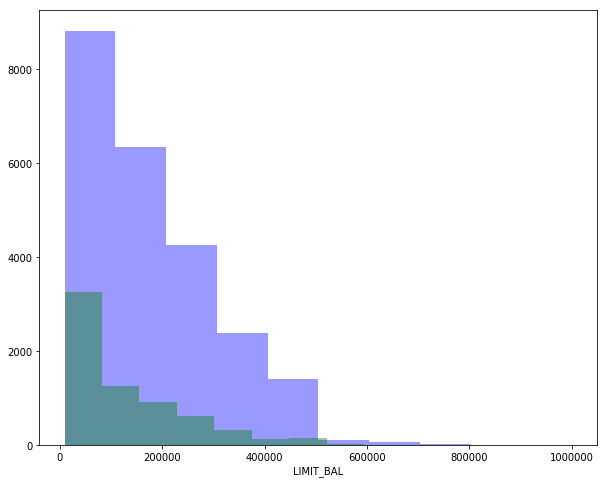

In [65]:
plt.figure(figsize=(10, 8))

current_palette = sns.color_palette("bright")
sns.set_palette(current_palette)

sns.distplot(lim_bal_0, bins=10, kde=False, color="blue", label="default = 0");
sns.distplot(lim_bal_1, bins=10, kde=False, color="green", label="default = 1");

plt.show()

Проверим гипотезу о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки.
- H0: медианные значения равны
- H1: медианные значения отличаются

In [66]:
print('Median LIMIT_BAL for default = 0: %.0f' % lim_bal_0.median())
print('Median LIMIT_BAL for default = 1: %.0f' % lim_bal_1.median())

Median LIMIT_BAL for default = 0: 150000
Median LIMIT_BAL for default = 1: 90000


### Точная оценка

In [67]:
lim_bal_0_s = np.sort(lim_bal_0.values)
lim_bal_1_s = np.sort(lim_bal_1.values)

In [68]:
def median_confidence_interval(data, alpha=0.05):
    n = len(data)
    m = np.median(data)
    z_stat = stats.norm.ppf(1 - alpha / 2)
    lower_element = (n / 2) - (z_stat * np.sqrt(n) / 2)
    upper_element = 1 + (n / 2) + (z_stat * np.sqrt(n) / 2)
    m_l = data[int(round(lower_element))]
    m_r = data[int(round(upper_element))]
    
    return m, m_l, m_r

In [69]:
print(median_confidence_interval(lim_bal_0_s))
print(median_confidence_interval(lim_bal_1_s))

(150000.0, 150000, 150000)
(90000.0, 80000, 90000)


### Bootstrap

In [70]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [71]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [72]:
np.random.seed(0)

lim_bal_0_median_scores = map(np.median, get_bootstrap_samples(lim_bal_0.values, 1000))
lim_bal_1_median_scores = map(np.median, get_bootstrap_samples(lim_bal_1.values, 1000))

lim_bal_0_median_scores = list(lim_bal_0_median_scores)
lim_bal_1_median_scores = list(lim_bal_1_median_scores)

print("95% confidence interval for the LIMIT_BAL median for default = 0:",  stat_intervals(lim_bal_0_median_scores, 0.05))
print("95% confidence interval for the LIMIT_BAL median for default = 1:",  stat_intervals(lim_bal_1_median_scores, 0.05))

95% confidence interval for the LIMIT_BAL median for default = 0: [150000. 150000.]
95% confidence interval for the LIMIT_BAL median for default = 1: [80000. 90000.]


Как видно из интервальной оценки, медианы не совпадают. Заёмщики, которые не возвращают кредит, обычно берут меньшую сумму.

Проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Для проверки гипотезы подойдёт перестановочный критерий для независимых выборок.

- H0: распределения выборок полностью равны
- H1: распределения выборок отличаются на величину сдвига

In [84]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [85]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [86]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [87]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [88]:
print("p-value: %f" % permutation_test(lim_bal_0, lim_bal_1, max_permutations=1000))

p-value: 0.001000


P-value получается довольно маленьким и нулевая гипотеза отвергается на уровне значимости 0.05.

Результат является практически значимым, потому что разница в значениях медианы LIMIT_BAL значимо большая.

### Задача 2

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

SEX: пол клиента (1 = мужской, 2 = женский )

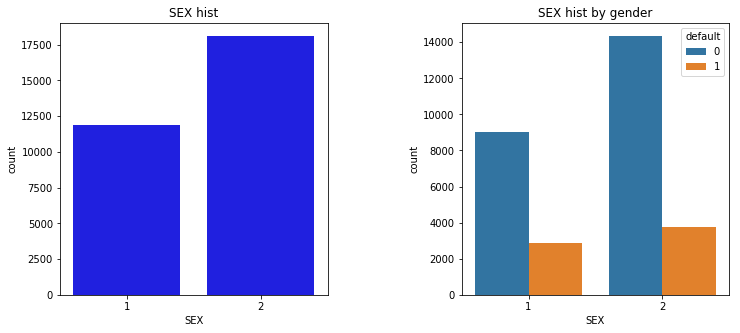

In [6]:
f, axes = plt.subplots(1, 2)

fig = plt.gcf()
fig.set_size_inches(12,5)

sns.countplot(x='SEX',data=credit_story, color="blue", ax=axes[0]);
sns.countplot(x='SEX', data=credit_story, hue='default', ax=axes[1]);

axes[0].set_title('SEX hist')
axes[1].set_title('SEX hist by gender')

plt.subplots_adjust(wspace=0.5)
plt.show()

In [7]:
print('Женщин, которые взяли кредит: ', len(credit_story[credit_story['SEX'] == 2]))
print('Мужчин, которые взяли кредит: ', len(credit_story[credit_story['SEX'] == 1]))

print('\nЖенщин от общего количества: %.2f' % (len(credit_story[credit_story['SEX'] == 2]) / len(credit_story)))

print('\nЖенщин, которые не вернули кредит: %.2f' % ((len(credit_story[(credit_story['SEX'] == 2) & (credit_story['default'] == 1)])) 
                                                     / len(credit_story[credit_story['SEX'] == 2])))
print('Мужчин, которые не вернули кредит: %.2f' % ((len(credit_story[(credit_story['SEX'] == 1) & (credit_story['default'] == 1)])) 
                                                     / len(credit_story[credit_story['SEX'] == 1])))

Женщин, которые взяли кредит:  18112
Мужчин, которые взяли кредит:  11888

Женщин от общего количества: 0.60

Женщин, которые не вернули кредит: 0.21
Мужчин, которые не вернули кредит: 0.24


Женщины берут больше кредитов, а мужчины более склонны к невозврату кредита.

### Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.

In [177]:
# samples of SEX for default = 0/1
sex_0 = credit_story[credit_story['default'] == 0]['SEX'].values
sex_1 = credit_story[credit_story['default'] == 1]['SEX'].values

In [165]:
# proportions of men to women in samples
m_to_w_0 = np.where(sex_0 == 1)[0].shape[0] / sex_0.shape[0]
m_to_w_1 = np.where(sex_1 == 1)[0].shape[0] / sex_1.shape[0]

print('Prop. of men for default = 0: %.4f' % m_to_w_0)
print('Prop. of men for default = 1: %.4f' % m_to_w_1)

Prop. of men for default = 0: 0.3859
Prop. of men for default = 1: 0.4329


Воспользуемя доверительным интервалом для доли на основе нормального распределения.

In [182]:
# Confident intervals for proportions
conf_int_0 = proportion_confint(np.where(sex_0 == 1)[0].shape[0], sex_0.shape[0])
conf_int_1 = proportion_confint(np.where(sex_1 == 1)[0].shape[0], sex_1.shape[0])

print('Conf. int. for prop. of men or default = 0: [%.4f, %.4f]' % conf_int_0)
print('Conf. int. for prop. of men or default = 1: [%.4f, %.4f]' % conf_int_1)

Conf. int. for prop. of men or default = 0: [0.3796, 0.3921]
Conf. int. for prop. of men or default = 1: [0.4210, 0.4449]


Как видно из интервальных оценок, сами интервалы не пересекаются, следовательно гендерный состав различается.

Построим доверительный интервал для разности двух долей независимых выборок.

In [183]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    
    return (left_boundary, right_boundary)

In [184]:
print('Conf. int. for difference: [%f, %f]' % proportions_confint_diff_ind(np.abs(sex_0-2), np.abs(sex_1-2)))

Conf. int. for difference: [-0.060548, -0.033635]


Используем статистический Z-критерий для доли для двух независимых выборок.

- H0: гендерный состав не отличается
- H1: гендерный состав отличается

In [185]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [186]:
def proportions_diff_z_test(z_stat, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [187]:
print('p-value: %.15f' % proportions_diff_z_test(proportions_diff_z_stat_ind(np.abs(sex_0-2), np.abs(sex_1-2))))

p-value: 0.000000000004473


Гипотеза о равенстве гендерного распределния отвергается. Данный результат явлется и практически значимым, т.к. 6% существенная величина для банков.

### Задача 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5 = прочее; 6 = нет данных)

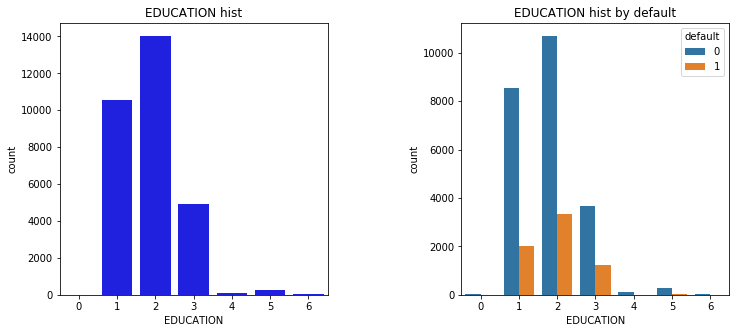

In [8]:
f, axes = plt.subplots(1, 2)

fig = plt.gcf()
fig.set_size_inches(12,5)

sns.countplot(x='EDUCATION',data=credit_story, color="blue", ax=axes[0]);
sns.countplot(x='EDUCATION', data=credit_story, hue='default', ax=axes[1]);

axes[0].set_title('EDUCATION hist')
axes[1].set_title('EDUCATION hist by default')

plt.subplots_adjust(wspace=0.5)
plt.show()

Кредиты в основном берут магистры, бакалавры и выпускники школ.

### Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг.

In [9]:
# Samples of EDUCATION for default = 0/1
edu_0 = credit_story[credit_story['default'] == 0]['EDUCATION'].values
edu_1 = credit_story[credit_story['default'] == 1]['EDUCATION'].values

In [10]:
credit_story['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [11]:
edu_prop = []
edu = credit_story['EDUCATION']

for i in np.unique(edu):
    edu_val = np.where(edu_0 == i)[0].shape[0] / (np.where(edu_1 == i)[0].shape[0] + np.where(edu_0 == i)[0].shape[0])
    edu_prop.append(edu_val)

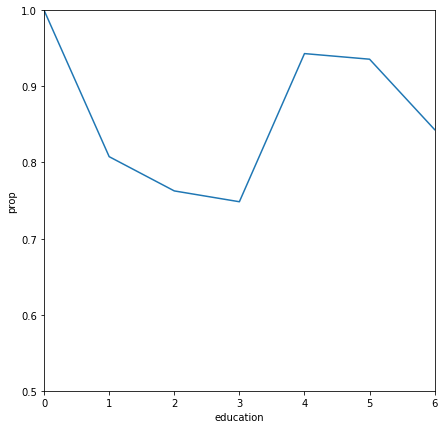

In [12]:
plt.figure(figsize=(7, 7))

plt.plot(np.unique(edu), edu_prop);
plt.axis([0, 6, 0.5, 1])
plt.xlabel('education')
plt.ylabel('prop')
plt.show()

Исходя из графика видно, что распределние не является равномерным, следовательно, образование влияет на то, вернёт ли человек долг. Реже всего возвращают долги категории 2 и 3 (бакалавры и выпускники школ). Возвращают все долги только люди с докторской степенью.

### Произведём строгую проверку на соответствие данного распределения равномерному с помощью критерия согласия Пирсона хи-квадрат.

- H0: рассматривая величина имеет равномерное распределение
- H1: H0 не верна

Посчитаем среднее значение доли возврата кредитов среди различных уровней образования. Будем использовать эту оценку для построения ожидаемого равномерного распределения.

In [13]:
prop_mean = np.asarray(edu_prop).mean()
print('Mean proportion value: %.2f' % prop_mean)

Mean proportion value: 0.86


In [17]:
# Total credit story
edu_sum = credit_story['EDUCATION'].value_counts().sort_index()
edu_sum

0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: EDUCATION, dtype: int64

In [18]:
# Observed distribution
edu_obs = credit_story[credit_story['default'] == 0]['EDUCATION'].value_counts().sort_index()
edu_obs

0       14
1     8549
2    10700
3     3680
4      116
5      262
6       43
Name: EDUCATION, dtype: int64

In [38]:
# Expected distribution
edu_exp = (round(edu_sum * prop_mean)).astype(int)
edu_exp

0       12
1     9134
2    12107
3     4243
4      106
5      242
6       44
Name: EDUCATION, dtype: int32

In [39]:
# Chi-square criterion
stats.chisquare(edu_obs, edu_exp, ddof = 1)

Power_divergenceResult(statistic=278.63624931992223, pvalue=3.907958481011075e-58)

Гипотеза о том, что величина имеет равномерное распределение отвергается с очень высокой долей вероятности.

Результат имеет практическую значимость для выдачи кредита, доли возврата значимо отличаются для разных уровней образования.

### Задача 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

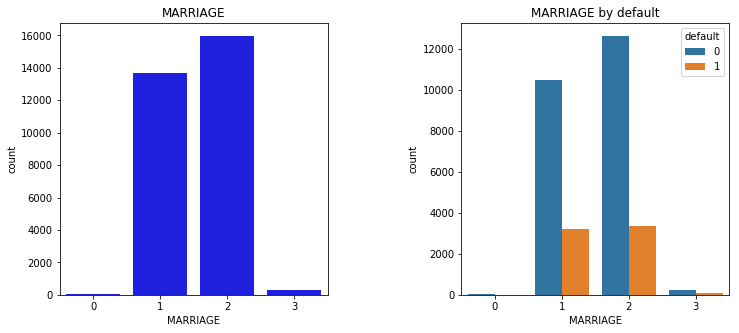

In [5]:
f, axes = plt.subplots(1, 2)

fig = plt.gcf()
fig.set_size_inches(12,5)

sns.countplot(x='MARRIAGE',data=credit_story, color="blue", ax=axes[0]);
sns.countplot(x='MARRIAGE', data=credit_story, hue='default', ax=axes[1]);

axes[0].set_title('MARRIAGE')
axes[1].set_title('MARRIAGE by default')

plt.subplots_adjust(wspace=0.5)
plt.show()

In [9]:
print('Value counts for marriage:')
credit_story['MARRIAGE'].value_counts()

Value counts for marriage:


2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [12]:
print('Не вернули кредит:')
print('Отказываюсь отвечать: %.2f' % ((len(credit_story[(credit_story['MARRIAGE'] == 0) & (credit_story['default'] == 1)])) 
                                                     / len(credit_story[credit_story['MARRIAGE'] == 0])))
print('Замужем/женат: %.2f' % ((len(credit_story[(credit_story['MARRIAGE'] == 1) & (credit_story['default'] == 1)])) 
                                                     / len(credit_story[credit_story['MARRIAGE'] == 1])))
print('Холост: %.2f' % ((len(credit_story[(credit_story['MARRIAGE'] == 2) & (credit_story['default'] == 1)])) 
                                                     / len(credit_story[credit_story['MARRIAGE'] == 2])))
print('Нет данных: %.2f' % ((len(credit_story[(credit_story['MARRIAGE'] == 3) & (credit_story['default'] == 1)])) 
                                                     / len(credit_story[credit_story['MARRIAGE'] == 3])))

Не вернули кредит:
Отказываюсь отвечать: 0.09
Замужем/женат: 0.23
Холост: 0.21
Нет данных: 0.26


### Проверим, как связан семейный статус с индикатором дефолта.

In [20]:
# Samples of MARRIAGE for default = 0/1
mar = credit_story['MARRIAGE']
mar_0 = credit_story[credit_story['default'] == 0]['MARRIAGE'].value_counts().sort_index()
mar_1 = credit_story[credit_story['default'] == 1]['MARRIAGE'].value_counts().sort_index()

Составим таблицу сопряжённости для признаков default и MARRIAGE.

In [21]:
mar_0

0       49
1    10453
2    12623
3      239
Name: MARRIAGE, dtype: int64

In [22]:
mar_1

0       5
1    3206
2    3341
3      84
Name: MARRIAGE, dtype: int64

In [35]:
mar_cros = pd.crosstab(credit_story['MARRIAGE'], credit_story['default'])

In [36]:
mar_cros

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


Вычислим коэффициент V Крамера.

In [37]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [38]:
print('V Cramer stat value: %.4f' % cramers_stat(mar_cros.values))

V Cramer stat value: 0.0345


Коэффициент Крамера принимает значение, близкое к нулю, когда взаимосвязь отсутствует.

Практическая значимость в данном результате также присутствует, т.к. исходя из этих данных нет разницы в том, с каким статусом MARRIAGE приходит человек за кредитом.

### Задача 5

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

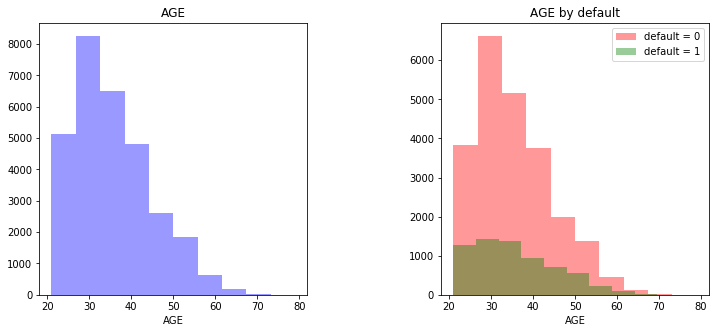

In [55]:
f, axes = plt.subplots(1, 2)

fig = plt.gcf()
fig.set_size_inches(12,5)

sns.distplot(credit_story['AGE'], bins=10, kde=False, color="blue", label="default = 0", ax=axes[0]);

sns.distplot(credit_story[credit_story['default'] == 0]['AGE'], bins=10, kde=False, color="red", label="default = 0", ax=axes[1]);
sns.distplot(credit_story[credit_story['default'] == 1]['AGE'], bins=10, kde=False, color="green", label="default = 1", ax=axes[1]);

axes[0].set_title('AGE')
axes[1].set_title('AGE by default')

plt.subplots_adjust(wspace=0.5)
plt.legend()
plt.show()

Молодые люди склонные не возвращать кредиты.

### Проверим гипотезу о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки.

- H0: медианные значения равны
- H1: медианные значения отличаются

In [58]:
# Samples of AGE for default = 0/1
age_0 = credit_story[credit_story['default'] == 0]['AGE']
age_1 = credit_story[credit_story['default'] == 1]['AGE']

print('Median AGE for default = 0: %.0f' % age_0.median())
print('Median AGE for default = 1: %.0f' % age_1.median())

Median AGE for default = 0: 34
Median AGE for default = 1: 34


### Доверительный интервал для медианы на основе бутстрепа.

In [74]:
# Confidence intervals estimation
np.random.seed(0)

age_0_bs_med = list(map(np.median, get_bootstrap_samples(age_0.values, 100)))
age_1_bs_med = list(map(np.median, get_bootstrap_samples(age_1.values, 100)))

bnd_0 = stat_intervals(age_0_bs_med, 0.05)
bnd_1 = stat_intervals(age_1_bs_med, 0.05)

print('Conf. int. median AGE for default = 0: [%f, %f]' % (bnd_0[0], bnd_0[1]))
print('Conf. int. median AGE for default = 1: [%f, %f]' % (bnd_1[0], bnd_1[1]))

Conf. int. median AGE for default = 0: [34.000000, 34.000000]
Conf. int. median AGE for default = 1: [34.000000, 35.000000]


Как видно из интервальной оценки, интервальные оценки для медианы пересекаются.

### Построим интервальную оценку для разности медиан.

In [76]:
print('Difference between medians: %f' % (np.median(age_0) - np.median(age_1)))

Difference between medians: 0.000000


In [79]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(age_0_bs_med, age_1_bs_med)))

In [80]:
stat_int = stat_intervals(delta_median_scores, 0.05)
print('95%% conf. int. for the difference between medians: [%f, %f]' % (stat_int[0], stat_int[1]))

95% conf. int. for the difference between medians: [0.000000, 1.000000]


Поскольку доверительный интервал содержит ноль, значения медиан не различаются.

### Проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.
Для проверки гипотезы подойдёт перестановочный критерий для независимых выборок.

- H0: распределения выборок полностью равны
- H1: распределения выборок отличаются на величину сдвига

In [89]:
print('p-value: %f' % permutation_test(age_0, age_1, max_permutations=1000))

p-value: 0.029000


P-value получается довольно маленьким и нулевая гипотеза отвергается на уровне значимости 0.05.

Результат является практически значимым, потому что разница в распределениях видна невооружённым взглядом и эти данные могут учитываться при выдаче кредита.